<a href="https://colab.research.google.com/github/ferdyanggara/indonlu/blob/master/project4211.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning Twitter SA
TwitterSA is a Sentiment Analysis dataset with 3 possible labels: `positive`, `negative`, `irrelevant` and `neutral`

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing Dependencies

In [4]:
pip install -r drive/MyDrive/project4211/requirements.txt

     |████████████████████████████████| 635 kB 594 kB/s 
     |████████████████████████████████| 11.3 MB 37.3 MB/s 
     |████████████████████████████████| 20.0 MB 1.3 MB/s 
     |████████████████████████████████| 7.0 MB 10.9 MB/s 
     |████████████████████████████████| 412.3 MB 25 kB/s 
     |████████████████████████████████| 752.0 MB 9.4 kB/s 
     |████████████████████████████████| 1.5 MB 34.7 MB/s 
     |████████████████████████████████| 238 kB 22.8 MB/s 
     |████████████████████████████████| 895 kB 39.8 MB/s 
     |████████████████████████████████| 5.6 MB 22.7 MB/s 
     |████████████████████████████████| 1.2 MB 51.1 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 3.8 MB 40.6 MB/s 
     |████████████████████████████████| 503 kB 38.9 MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-py3-none-any.whl size=1449922 sha256=13eba26923ac7046d8990d69fb1d934ade0701b6528deab3cb2c1eade1dcfd7a
  Stored in directory: /root/.cache/pip/w

# Import Statement

In [98]:
import os, sys

import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split

In [99]:
import string
import torch
import re
from torch.utils.data import Dataset, DataLoader

In [100]:
import itertools
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


Import dataset

In [101]:
train = pd.read_csv('drive/MyDrive/project4211/twitter_training.csv', header=None)
test = pd.read_csv('drive/MyDrive/project4211/twitter_validation.csv', header=None)

Dropping missing Values

In [102]:
train.dropna(inplace=True)
test.dropna(inplace=True)

Splitting training and testing 

In [108]:
train, valid = train_test_split(train, test_size=0.2, stratify=train.iloc[:,2])

valid = valid.iloc[:, [2,3]]
valid.columns = ['sentiment', 'text']

train = train.iloc[:, [2,3]]
train.columns = ['sentiment', 'text']

test = test.iloc[:, [2,3]]
test.columns = ['sentiment', 'text']

Store dataset in tsv format

In [109]:
train.to_csv("train.tsv", sep="\t", index=False, header=None)
valid.to_csv("valid.tsv", sep="\t", index=False, header=None)
test.to_csv("test.tsv", sep="\t", index=False, header=None)

Dataset & Dataloader Class

In [110]:
class DocumentSentimentDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = {'Positive': 0, 'Neutral': 1, 'Negative': 2, 'Irrelevant': 3}
    INDEX2LABEL = {0: 'Positive', 1: 'Neutral', 2: 'Negative', 3: 'Irrelevant'}
    NUM_LABELS = 4
    
    def load_dataset(self, path): 
        df = pd.read_csv(path, sep='\t', header=None)
        df.columns = ['sentiment','text']
        df['sentiment'] = df['sentiment'].apply(lambda lab: self.LABEL2INDEX[lab])
        return df
    
    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token
    
    def __getitem__(self, index):
        data = self.data.loc[index,:]
        text, sentiment = data['text'], data['sentiment']
        subwords = self.tokenizer.encode(text, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(sentiment), data['text']
    
    def __len__(self):
        return len(self.data)    
        
class DocumentSentimentDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(DocumentSentimentDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len
        
    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)
        
        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        sentiment_batch = np.zeros((batch_size, 1), dtype=np.int64)
        
        seq_list = []
        for i, (subwords, sentiment, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            sentiment_batch[i,0] = sentiment
            
            seq_list.append(raw_seq)
            
        return subword_batch, mask_batch, sentiment_batch, seq_list


In [111]:
def document_sentiment_metrics_fn(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics


In [112]:
# Forward function for sequence classification
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)
            
    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]
    
    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label


In [143]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [114]:
# Set random seed
set_seed(26112021)

# Load Model

In [162]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')
config = BertConfig.from_pretrained('prajjwal1/bert-tiny')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', config=config)



In [163]:
model


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, element

In [164]:
count_param(model)


4386436

# Prepare Dataset

In [118]:
train_dataset_path = './train.tsv'
valid_dataset_path = './valid.tsv'
test_dataset_path = './test.tsv'

In [119]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)  
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

In [120]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'Positive': 0, 'Neutral': 1, 'Negative': 2, 'Irrelevant': 3}
{0: 'Positive', 1: 'Neutral', 2: 'Negative', 3: 'Irrelevant'}


In [121]:
train_dataset.data.loc[train_dataset.data.text.isna()]

,sentiment,text


In [122]:
 for batch in train_loader:
   break

# Test model on sample sentences

In [165]:
# negative
text = '@Borderlands how do I submit a complaint? Your CEO isnt paying his staff their bonuses.'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: @Borderlands how do I submit a complaint? Your CEO isnt paying his staff their bonuses. | Label : Positive (29.979%)


In [166]:
# Neutral 
text = 'BITCH ASS LEGEND VIP’D MY LITTLE BROTHER ON OUR 2 GAME WIN STREAK SMFH @Ronnie2K @NBA2K pic.twitter.com/GdS3KN9jVj'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: BITCH ASS LEGEND VIP’D MY LITTLE BROTHER ON OUR 2 GAME WIN STREAK SMFH @Ronnie2K @NBA2K pic.twitter.com/GdS3KN9jVj | Label : Positive (30.881%)


In [167]:
# positive
text = '3.7k to 3.2k 🙃 I LOVE DOTA 2 PUTANG INA'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: 3.7k to 3.2k 🙃 I LOVE DOTA 2 PUTANG INA | Label : Positive (32.881%)


# Fine Tuning & Evaluation

In [168]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model = model.cuda()

In [169]:
# Train
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        # metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f}".format(total_loss/(i+1)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

(Epoch 1) TRAIN LOSS:1.0200 LR:0.00010000: 100%|██████████| 1850/1850 [01:30<00:00, 20.36it/s]


(Epoch 1) TRAIN LOSS:1.0200 ACC:0.58 F1:0.55 REC:0.55 PRE:0.57 LR:0.00010000


VALID LOSS:0.7786: 100%|██████████| 463/463 [00:16<00:00, 27.82it/s]


(Epoch 1) VALID LOSS:0.7786 ACC:0.70 F1:0.69 REC:0.69 PRE:0.69


(Epoch 2) TRAIN LOSS:0.6499 LR:0.00010000: 100%|██████████| 1850/1850 [01:30<00:00, 20.39it/s]


(Epoch 2) TRAIN LOSS:0.6499 ACC:0.76 F1:0.75 REC:0.75 PRE:0.75 LR:0.00010000


VALID LOSS:0.5677: 100%|██████████| 463/463 [00:16<00:00, 27.54it/s]


(Epoch 2) VALID LOSS:0.5677 ACC:0.79 F1:0.78 REC:0.78 PRE:0.78


(Epoch 3) TRAIN LOSS:0.4418 LR:0.00010000: 100%|██████████| 1850/1850 [01:30<00:00, 20.44it/s]


(Epoch 3) TRAIN LOSS:0.4418 ACC:0.84 F1:0.83 REC:0.83 PRE:0.84 LR:0.00010000


VALID LOSS:0.4590: 100%|██████████| 463/463 [00:16<00:00, 27.62it/s]


(Epoch 3) VALID LOSS:0.4590 ACC:0.83 F1:0.83 REC:0.83 PRE:0.83


(Epoch 4) TRAIN LOSS:0.3307 LR:0.00010000: 100%|██████████| 1850/1850 [01:29<00:00, 20.59it/s]


(Epoch 4) TRAIN LOSS:0.3307 ACC:0.88 F1:0.88 REC:0.87 PRE:0.88 LR:0.00010000


VALID LOSS:0.4071: 100%|██████████| 463/463 [00:16<00:00, 27.79it/s]


(Epoch 4) VALID LOSS:0.4071 ACC:0.86 F1:0.86 REC:0.85 PRE:0.87


(Epoch 5) TRAIN LOSS:0.2662 LR:0.00010000: 100%|██████████| 1850/1850 [01:29<00:00, 20.65it/s]


(Epoch 5) TRAIN LOSS:0.2662 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.00010000


VALID LOSS:0.4024: 100%|██████████| 463/463 [00:16<00:00, 27.97it/s]


(Epoch 5) VALID LOSS:0.4024 ACC:0.87 F1:0.86 REC:0.86 PRE:0.87


(Epoch 6) TRAIN LOSS:0.2242 LR:0.00010000: 100%|██████████| 1850/1850 [01:29<00:00, 20.66it/s]


(Epoch 6) TRAIN LOSS:0.2242 ACC:0.92 F1:0.92 REC:0.91 PRE:0.92 LR:0.00010000


VALID LOSS:0.3707: 100%|██████████| 463/463 [00:16<00:00, 28.00it/s]


(Epoch 6) VALID LOSS:0.3707 ACC:0.88 F1:0.88 REC:0.88 PRE:0.88


(Epoch 7) TRAIN LOSS:0.1877 LR:0.00010000: 100%|██████████| 1850/1850 [01:30<00:00, 20.44it/s]


(Epoch 7) TRAIN LOSS:0.1877 ACC:0.93 F1:0.93 REC:0.93 PRE:0.93 LR:0.00010000


VALID LOSS:0.3584: 100%|██████████| 463/463 [00:16<00:00, 27.86it/s]


(Epoch 7) VALID LOSS:0.3584 ACC:0.89 F1:0.88 REC:0.88 PRE:0.89


(Epoch 8) TRAIN LOSS:0.1666 LR:0.00010000: 100%|██████████| 1850/1850 [01:30<00:00, 20.41it/s]


(Epoch 8) TRAIN LOSS:0.1666 ACC:0.94 F1:0.94 REC:0.93 PRE:0.94 LR:0.00010000


VALID LOSS:0.3563: 100%|██████████| 463/463 [00:17<00:00, 27.10it/s]


(Epoch 8) VALID LOSS:0.3563 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89


(Epoch 9) TRAIN LOSS:0.1482 LR:0.00010000: 100%|██████████| 1850/1850 [01:31<00:00, 20.19it/s]


(Epoch 9) TRAIN LOSS:0.1482 ACC:0.94 F1:0.94 REC:0.94 PRE:0.94 LR:0.00010000


VALID LOSS:0.3559: 100%|██████████| 463/463 [00:16<00:00, 27.39it/s]


(Epoch 9) VALID LOSS:0.3559 ACC:0.89 F1:0.89 REC:0.89 PRE:0.90


(Epoch 10) TRAIN LOSS:0.1347 LR:0.00010000: 100%|██████████| 1850/1850 [01:30<00:00, 20.42it/s]


(Epoch 10) TRAIN LOSS:0.1347 ACC:0.95 F1:0.95 REC:0.95 PRE:0.95 LR:0.00010000


VALID LOSS:0.3636: 100%|██████████| 463/463 [00:17<00:00, 26.96it/s]

(Epoch 10) VALID LOSS:0.3636 ACC:0.90 F1:0.89 REC:0.89 PRE:0.90


In [170]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

print(df)

100%|██████████| 32/32 [00:02<00:00, 14.88it/s]

     index       label
0        0  Irrelevant
1        1     Neutral
2        2    Negative
3        3    Negative
4        4     Neutral
..     ...         ...
995    995  Irrelevant
996    996  Irrelevant
997    997    Positive
998    998    Positive
999    999     Neutral

[1000 rows x 2 columns]


# Accuracy on test set

In [176]:
prediction = pd.read_csv('./pred.txt')

In [185]:
accuracy_score(test['sentiment'], prediction['label'])

0.941

#Confusion Matrix

In [181]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

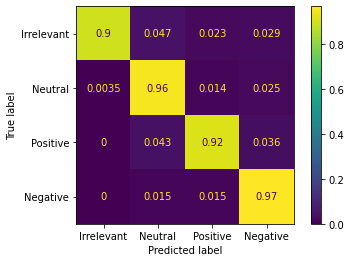

In [183]:
y_unique = list(set(prediction['label']))
cm = confusion_matrix(test['sentiment'], prediction['label'], labels = y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

# Test fine-tuned model on sample sentences

In [172]:
# negative
text = '@Borderlands how do I submit a complaint? Your CEO isnt paying his staff their bonuses.'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: @Borderlands how do I submit a complaint? Your CEO isnt paying his staff their bonuses. | Label : Negative (99.921%)


In [173]:
# positive
text = '3.7k to 3.2k 🙃 I LOVE DOTA 2 PUTANG INA'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: 3.7k to 3.2k 🙃 I LOVE DOTA 2 PUTANG INA | Label : Positive (99.820%)


In [69]:
# negative 
text = 'FIX IT JESUS ! Please FIX IT ! What In the world is going on here.  @PlayStation @AskPlayStation @Playstationsup @Treyarch @CallofDuty negative 345 silver wolf error code pic.twitter.com/ziRyhrf59Q'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: FIX IT JESUS ! Please FIX IT ! What In the world is going on here.  @PlayStation @AskPlayStation @Playstationsup @Treyarch @CallofDuty negative 345 silver wolf error code pic.twitter.com/ziRyhrf59Q | Label : Negative (98.502%)


In [175]:
# Neutral 
text = 'BITCH ASS LEGEND VIP’D MY LITTLE BROTHER ON OUR 2 GAME WIN STREAK SMFH @Ronnie2K @NBA2K pic.twitter.com/GdS3KN9jVj'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: BITCH ASS LEGEND VIP’D MY LITTLE BROTHER ON OUR 2 GAME WIN STREAK SMFH @Ronnie2K @NBA2K pic.twitter.com/GdS3KN9jVj | Label : Neutral (99.472%)


In [140]:
# irrelevant
text = '10 year olds trading on the stock market is scary news. It can instill good financial habits/curiosity. BUT. Equally high chances of it going the opposite way: seeding gambling tendencies, heavy losses from trading F&Os, or worse - this becoming the next Blue Whale. Not worth it.'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: 10 year olds trading on the stock market is scary news. It can instill good financial habits/curiosity. BUT. Equally high chances of it going the opposite way: seeding gambling tendencies, heavy losses from trading F&Os, or worse - this becoming the next Blue Whale. Not worth it. | Label : Irrelevant (99.912%)
